In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [ ]:
import os
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0


In [ ]:
from tensorflow_datasets import testing
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
#Agarramos todos los sonidos y los convertimos en mfcc
#Cargamos nuestro conjunto de datos

ds_path ='/content/drive/MyDrive/MusicDataSet/Data/genres_original'

# #Funcion que agarra un numero de audios para luego convertirlos a MFCC (Mel-frequency cepstral coefficient)

def audioMFCC(audio):
  audio_series , sample_rate = librosa.load(audio,duration = 30.0,res_type="soxr_hq")
  mfcc = librosa.feature.mfcc(y=audio_series, sr=sample_rate, n_mfcc=40)
  #np.ndarray [shape=(…, n_mfcc, t)]
  return mfcc,audio_series

datasetMFCC = []
labelsMFCC = []

# Obtener lista de géneros desde las carpetas
GENRE_CLASSES = sorted(os.listdir(ds_path))
#De la carpeta recorremos todos los elemento de ds_path para procesarlos y guardarlos en nuuestro vector

# Recorrer cada género y sus archivos
for label_index, genre in enumerate(GENRE_CLASSES):
    genre_path = os.path.join(ds_path, genre)

    if not os.path.isdir(genre_path):
        continue  # Ignorar archivos sueltos

    print(f"Procesando género: {genre}")
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)

            try:
                # Cargar el audio y convertirlo a MFCC
                y = file_path
                mfcc,audio_series = audioMFCC(file_path)

                # Si el audio es muy corto, lo ignoramos
                if len(audio_series) < 2048:
                    print(f"Audio muy corto, saltando: {file_path}")
                    continue


                datasetMFCC.append(mfcc)
                labelsMFCC.append(label_index)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")



Procesando género: blues
Procesando género: classical
Procesando género: country
Procesando género: disco
Procesando género: hiphop
Procesando género: jazz


<ipython-input-9-090a1b6cf51a>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_series , sample_rate = librosa.load(audio,duration = 30.0,res_type="soxr_hq")
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error procesando /content/drive/MyDrive/MusicDataSet/Data/genres_original/jazz/jazz.00054.wav: 
Procesando género: metal
Procesando género: pop
Procesando género: reggae
Procesando género: rock


Cantidad de MFCC: 999
Cantidad de etiquetas: 999
Tamaño de un MFCC: (40, 1292)


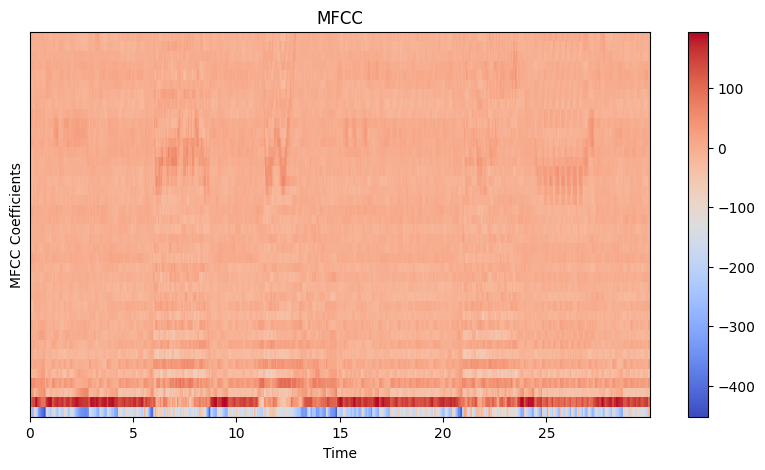

In [ ]:
print("Cantidad de MFCC:", len(datasetMFCC))
print("Cantidad de etiquetas:", len(labelsMFCC))
print("Tamaño de un MFCC:", datasetMFCC[0].shape)
plt.figure(figsize=(10, 5))
librosa.display.specshow(datasetMFCC[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
def pad_mfcc(mfcc, max_len=100):
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        return np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        return mfcc[:, :max_len]

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Modelo optimizado para dataset pequeño
def genreClassifier(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
BATCH_SIZE = 16  # menor para mejorar la generalización

X = np.array([pad_mfcc(mfcc) for mfcc in datasetMFCC])#, dtype=np.float32)
y = np.array(labelsMFCC, dtype=np.int32)
# División 80% entrenamiento, 20% validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

input_shape = X_train.shape[1:]
model = genreClassifier(input_shape)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)
model.save("genre_classifier_model_small_dataset.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.0953 - loss: 2.8994 - val_accuracy: 0.0950 - val_loss: 2.5049
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0788 - loss: 2.8553 - val_accuracy: 0.1000 - val_loss: 2.4575
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1192 - loss: 2.7345 - val_accuracy: 0.1200 - val_loss: 2.4428
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1549 - loss: 2.6641 - val_accuracy: 0.1250 - val_loss: 2.4124
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1103 - loss: 2.6343 - val_accuracy: 0.1250 - val_loss: 2.3780
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1263 - loss: 2.5933 - val_accuracy: 0.1350 - val_loss: 2.4091
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1226 - loss: 2.5920 - val_accuracy: 0.1200 - val_loss: 2.4011
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0893 - loss: 2.5807 - val_accuracy: 0.1000 - v

In [ ]:
plot_history(history)

NameError: name 'plot_history' is not defined

In [ ]:
# Para guardar después de entrenar (si no lo has hecho aún)

